# MindTrack — Improved ML Notebook

This notebook upgrades the ML pipeline with preprocessing pipelines, lag/rolling features, robust diagnostics, hyperparameter tuning, and saved pipeline for deployment. It assumes `dataset.csv` and `additional_dataset.csv` are present in `/mnt/data/`.


In [1]:

# Imports and helper functions
import os, sys, warnings, json
import pandas as pd, numpy as np
from datetime import datetime
warnings.filterwarnings('ignore')
print('Notebook started at', datetime.utcnow().isoformat())


Notebook started at 2025-10-26T02:47:03.918813


In [3]:

# Load datasets (robust checks)
base_path = '../data'
dataset_path = os.path.join(base_path, 'dataset.csv')
additional_path = os.path.join(base_path, 'additional_dataset.csv')

for p in [dataset_path, additional_path]:
    print(p, 'exists?' , os.path.exists(p))

# Load main dataset
if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path)
    print('Loaded dataset.csv with', len(df), 'rows')
else:
    raise FileNotFoundError(f"dataset.csv not found at {dataset_path}")

# Load additional (habit entries) if present
if os.path.exists(additional_path):
    additional = pd.read_csv(additional_path)
    print('Loaded additional_dataset.csv with', len(additional), 'rows')
else:
    print('additional_dataset.csv not found — some downstream cells will skip habit-based logic.')
    additional = pd.DataFrame()


../data\dataset.csv exists? True
../data\additional_dataset.csv exists? True
Loaded dataset.csv with 457 rows
Loaded additional_dataset.csv with 1371 rows


In [5]:

# Basic preprocessing & derived features
# Parse date columns (ActivityDate or date)
if 'ActivityDate' in df.columns:
    df['ActivityDate_parsed'] = pd.to_datetime(df['ActivityDate'], errors='coerce')
if 'date' in df.columns:
    df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')

if 'ActivityDate_parsed' in df.columns and df['ActivityDate_parsed'].notna().any():
    df['date'] = pd.to_datetime(df['ActivityDate_parsed']).dt.date
elif 'date_parsed' in df.columns:
    df['date'] = pd.to_datetime(df['date_parsed']).dt.date
else:
    df['date'] = pd.NaT

# Ensure numeric columns exist
for c in ['TotalSteps','VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes','Calories','minutes_asleep']:
    if c not in df.columns:
        df[c] = np.nan
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Derived features
df['total_active_minutes'] = df[['VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes']].sum(axis=1)
df['is_weekend'] = pd.to_datetime(df['date']).dt.weekday.isin([5,6]).astype(int)
df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()
df['steps_per_active_min'] = df['TotalSteps'] / df['total_active_minutes'].replace(0, np.nan)

# Rolling features (per user if Id exists, else global)
if 'Id' in df.columns:
    df['Id'] = df['Id'].astype(str)
    df = df.sort_values(['Id','date'])
    df['avg_steps_7d'] = df.groupby('Id')['TotalSteps'].transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['prev_day_sleep'] = df.groupby('Id')['minutes_asleep'].shift(1)
else:
    df = df.sort_values('date')
    df['avg_steps_7d'] = df['TotalSteps'].rolling(7, min_periods=1).mean()
    df['prev_day_sleep'] = df['minutes_asleep'].shift(1)

df['avg_sleep_7d'] = df['minutes_asleep'].rolling(7, min_periods=1).mean()

print('Derived features added. Sample:')
display(df[['date','TotalSteps','total_active_minutes','avg_steps_7d','minutes_asleep','prev_day_sleep']].head(8))


Derived features added. Sample:


,date,TotalSteps,total_active_minutes,avg_steps_7d,minutes_asleep,prev_day_sleep
0,2016-03-25,11004,250,11004.000000,424.0,NaN
1,2016-03-26,17609,380,14306.500000,511.0,424.0
2,2016-03-27,12736,329,13783.000000,533.0,511.0
3,2016-03-28,13231,283,13645.000000,81.0,533.0
4,2016-03-29,12041,299,13324.200000,411.0,81.0
5,2016-03-30,10970,266,12931.833333,480.0,411.0
6,2016-03-31,12256,284,12835.285714,365.0,480.0
7,2016-04-01,12262,268,13015.000000,333.0,365.0


Total rows: 457
Missing minutes_asleep: 0


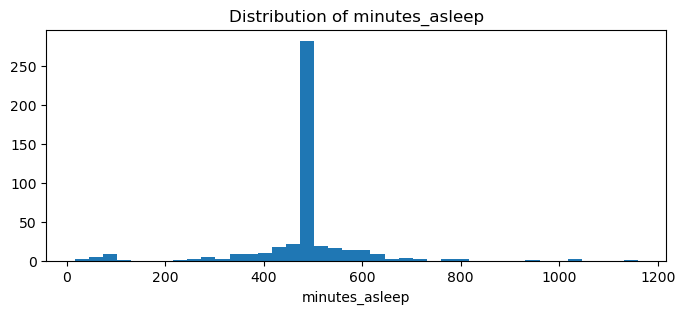

count     457.000000
mean      476.094092
std       114.112008
min        16.000000
25%       480.000000
50%       480.000000
75%       480.000000
max      1160.000000
Name: minutes_asleep, dtype: float64

Outlier rows (sleep <60 or >1440): 5


,date,minutes_asleep
68,2016-04-09,56.0
119,2016-04-09,25.0
231,2016-03-31,57.0
343,2016-04-01,16.0
387,2016-04-10,54.0


In [7]:

# Target diagnostics for minutes_asleep
print('Total rows:', len(df))
print('Missing minutes_asleep:', df['minutes_asleep'].isna().sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.hist(df['minutes_asleep'].dropna(), bins=40)
plt.title('Distribution of minutes_asleep')
plt.xlabel('minutes_asleep')
plt.show()

display(df['minutes_asleep'].describe())

# Identify outliers: very small or very large values
outliers = df[(df['minutes_asleep'] < 60) | (df['minutes_asleep'] > 1440)]
print('Outlier rows (sleep <60 or >1440):', len(outliers))
if len(outliers)>0:
    display(outliers[['date','minutes_asleep']].head(8))


In [11]:

# Create ML dataset: drop rows without minutes_asleep and optionally trim extremes
df_ml = df.dropna(subset=['minutes_asleep']).copy()
# Optionally remove extreme outliers (sleep < 60 or > 12*60)
initial_rows = len(df_ml)
df_ml = df_ml[(df_ml['minutes_asleep'] >= 60) & (df_ml['minutes_asleep'] <= 12*60)]
print(f'Removed {initial_rows - len(df_ml)} extreme rows; remaining {len(df_ml)} rows for ML.')


Removed 14 extreme rows; remaining 443 rows for ML.


In [13]:

# Features to use
feature_cols = ['TotalSteps','VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes','Calories','total_active_minutes','avg_steps_7d','prev_day_sleep','is_weekend']

for c in feature_cols:
    if c not in df_ml.columns:
        df_ml[c] = 0

# Ensure date is datetime
df_ml['date'] = pd.to_datetime(df_ml['date'])

# Temporal split by date: first 80% dates -> train, last 20% -> test
unique_dates = sorted(df_ml['date'].dt.date.unique())
if len(unique_dates) >= 5:
    split_idx = int(len(unique_dates)*0.8)
    split_date = unique_dates[split_idx]
    train_df = df_ml[df_ml['date'].dt.date <= split_date].copy()
    test_df = df_ml[df_ml['date'].dt.date > split_date].copy()
    print('Temporal split at date', split_date, '; train rows:', len(train_df), 'test rows:', len(test_df))
else:
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(df_ml, test_size=0.2, random_state=42)
    print('Random split used; train rows:', len(train_df), 'test rows:', len(test_df))

X_train = train_df[feature_cols]
y_train = train_df['minutes_asleep']
X_test = test_df[feature_cols]
y_test = test_df['minutes_asleep']


Temporal split at date 2016-04-06 ; train rows: 275 test rows: 168


In [15]:

# Baseline: predict mean sleep
import numpy as np
mean_pred = np.mean(y_train)
baseline_mae = np.mean(np.abs(y_test - mean_pred))
print(f'Baseline mean predictor MAE: {baseline_mae:.2f} minutes')


Baseline mean predictor MAE: 41.48 minutes


In [17]:

# Build preprocessing + model pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

numeric_feats = feature_cols  # all numeric here
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_feats)], remainder='drop')

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf)])

# Hyperparameter grid for randomized search
param_dist = {
    'model__n_estimators': [100,200,400],
    'model__max_depth': [5,10,20,None],
    'model__min_samples_leaf': [1,2,4,8]
}

rs = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=12, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
best_pipeline = rs.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__n_estimators': 200, 'model__min_samples_leaf': 4, 'model__max_depth': 10}


In [18]:

# Evaluate on test
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
preds = best_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)
print(f'Test MAE: {mae:.2f} minutes')
print(f'Test RMSE: {rmse:.2f} minutes')
print(f'Test R2: {r2:.3f}')

print('\nCompare to baseline:')
print(f'Baseline MAE: {baseline_mae:.2f} minutes')

# Feature importances (if model exposes them)
try:
    model = best_pipeline.named_steps['model']
    importances = model.feature_importances_
    feat_imp = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
    print('\nTop features:')
    for f,i in feat_imp[:10]:
        print(f, f'{i:.3f}')
except Exception as e:
    print('Could not extract feature importances:', e)


Test MAE: 64.05 minutes
Test RMSE: 94.13 minutes
Test R2: -0.350

Compare to baseline:
Baseline MAE: 41.48 minutes

Top features:
SedentaryMinutes 0.429
avg_steps_7d 0.110
total_active_minutes 0.087
Calories 0.077
prev_day_sleep 0.074
TotalSteps 0.065
LightlyActiveMinutes 0.065
FairlyActiveMinutes 0.042
VeryActiveMinutes 0.038
is_weekend 0.013


In [21]:

# Save the trained pipeline for backend integration
import joblib
out_pipeline = os.path.join('../data','pipeline.pkl')
joblib.dump(best_pipeline, out_pipeline)
print('Saved pipeline to', out_pipeline)


Saved pipeline to ../data\pipeline.pkl


Computed SHAP values. Displaying summary plot...


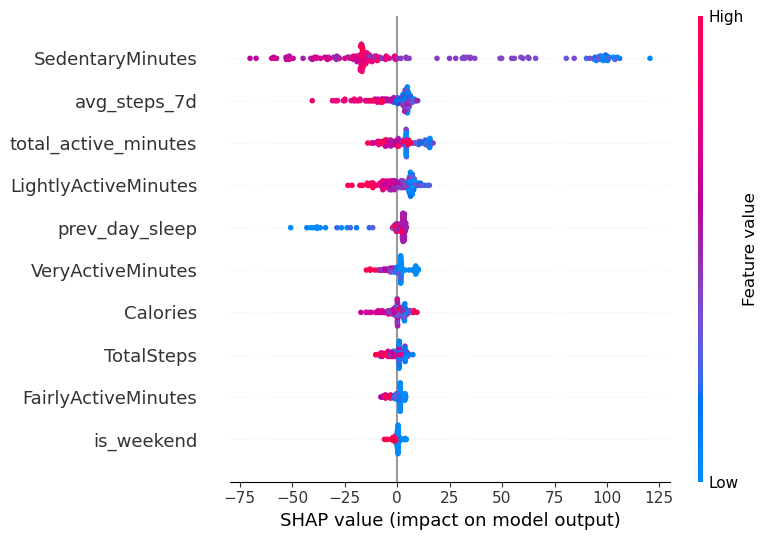

In [23]:

# Optional: SHAP explanation (will only run if shap is installed)
try:
    import shap
    explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])
    # need to transform X_test through preprocessor to get numeric array
    X_test_trans = best_pipeline.named_steps['preprocessor'].transform(X_test)
    shap_values = explainer.shap_values(X_test_trans)
    print('Computed SHAP values. Displaying summary plot...')
    shap.summary_plot(shap_values, X_test_trans, feature_names=feature_cols)
except Exception as e:
    print('SHAP not available or failed:', e)


In [29]:

# Demo: how to call pipeline on raw input dict (example)
sample = X_test.iloc[0:1].to_dict(orient='records')[0]
print('Sample raw input dict:')
print(sample)
# Convert to DataFrame and predict
sample_df = pd.DataFrame([sample])
loaded = joblib.load('../data/pipeline.pkl')
pred = loaded.predict(sample_df)
print('Predicted minutes_asleep for sample:', pred[0])
print('Actual:', y_test.iloc[0])


Sample raw input dict:
{'TotalSteps': 10198, 'VeryActiveMinutes': 17, 'FairlyActiveMinutes': 20, 'LightlyActiveMinutes': 195, 'SedentaryMinutes': 1208, 'Calories': 1755, 'total_active_minutes': 232, 'avg_steps_7d': 12157.0, 'prev_day_sleep': 480.0, 'is_weekend': 0}
Predicted minutes_asleep for sample: 453.39918952922073
Actual: 480.0


## Notes
- This notebook trims extreme sleep values and uses temporal splitting.
- The pipeline (pipeline.pkl) contains preprocessing and model and is ready for backend use.
- If you need SHAP visual PNG saved instead of inline, I can add that.
